# Dominik 2024

In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q

In [78]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]
filename = os.path.join('NVcenter', 'data', 'dominik_bath_small')
directory = os.getcwd()

bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

# Bell (Hadamard and CNOT)
init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

## Effect of the spin bath for free time evolution

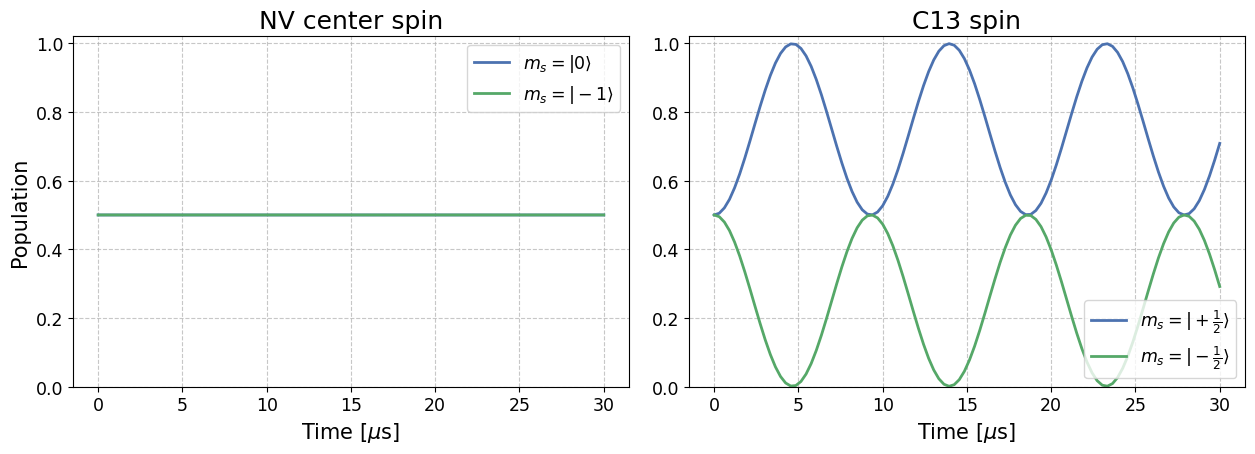

In [88]:
# free time evolution of the entangled Bell state between NV center and C13 spin (Dominik Fig. 4)

kwargs = dict(env_approx_level='no_bath', suter_method=True, instant_pulses=True, verbose=False, target=bell_state, thermal_bath=False, old_register_state=bell_state)
env = Environment(register_config, bath_configs, **kwargs)
pulse_seq = [30e-6]
t_list = np.linspace(0, 30e-6, 100)
    
new_states = env.get_new_register_states(pulse_seq, t_list=t_list)
fig, ax = plot_pops(t_list, new_states)

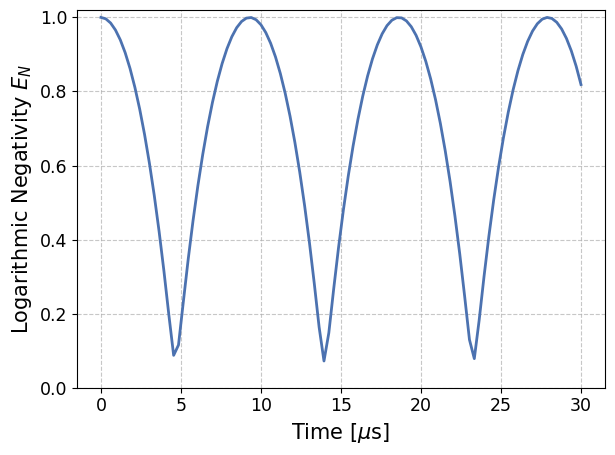

In [73]:
log_negativities = [calc_logarithmic_negativity(new_state) for new_state in new_states] 
fig, ax = plot_log_negativity(t_list, log_negativities)

### Results for different approximation levels

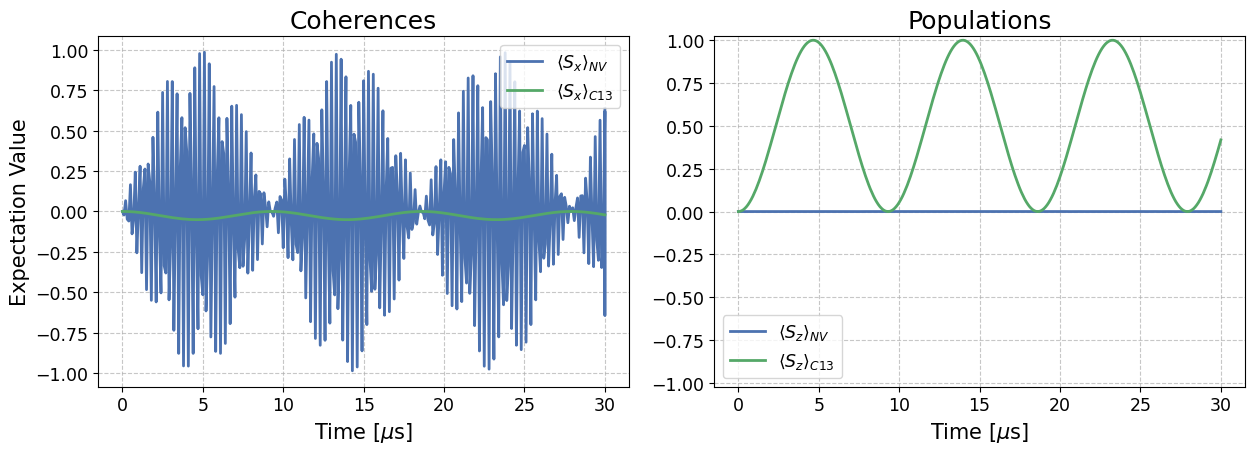

In [5]:
# no_bath
fig, ax = plot_exp_values(t_list, new_states)

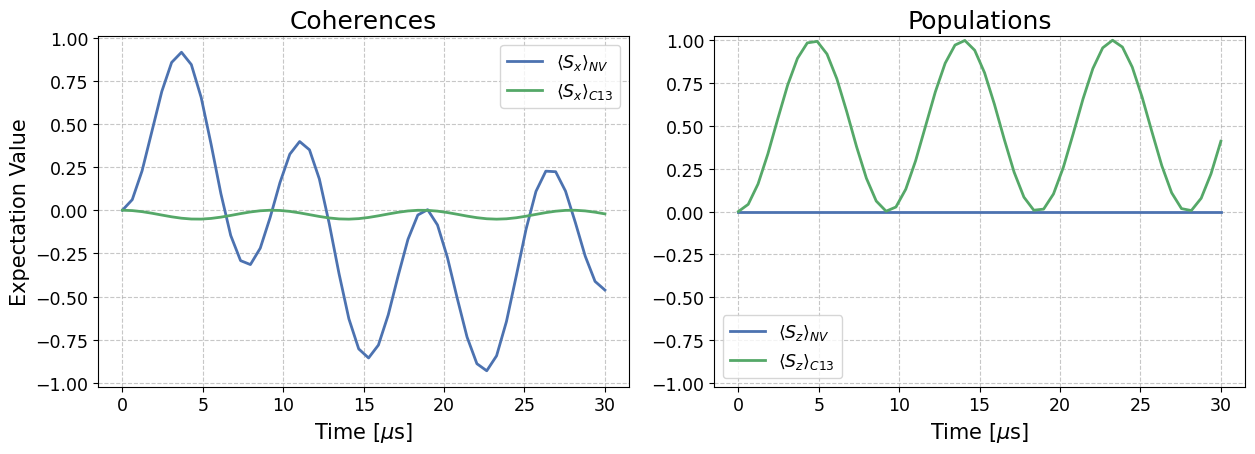

In [13]:
# gCCE0
fig, ax = plot_exp_values(t_list, new_states)

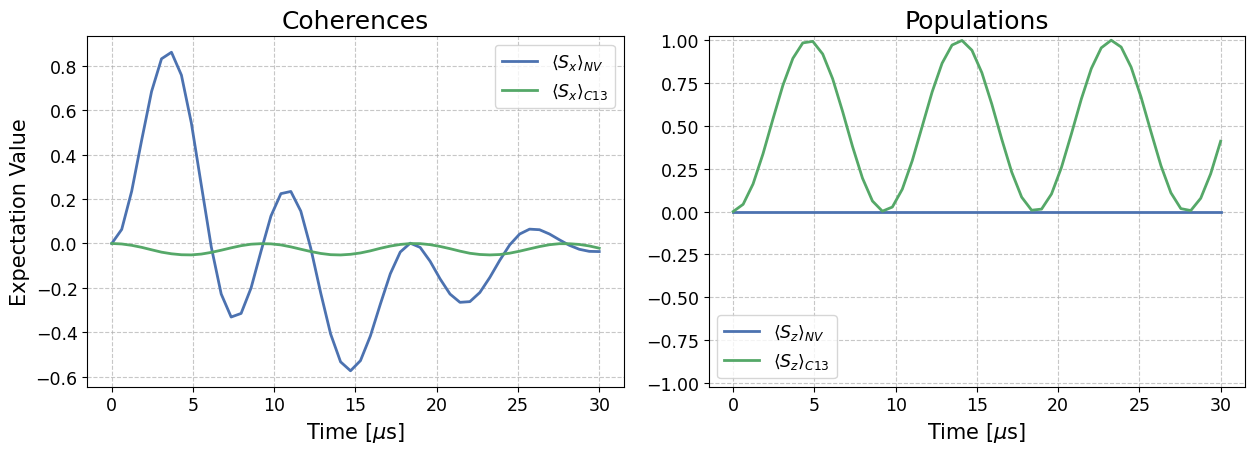

In [20]:
# gCCE1
fig, ax = plot_exp_values(t_list, new_states)

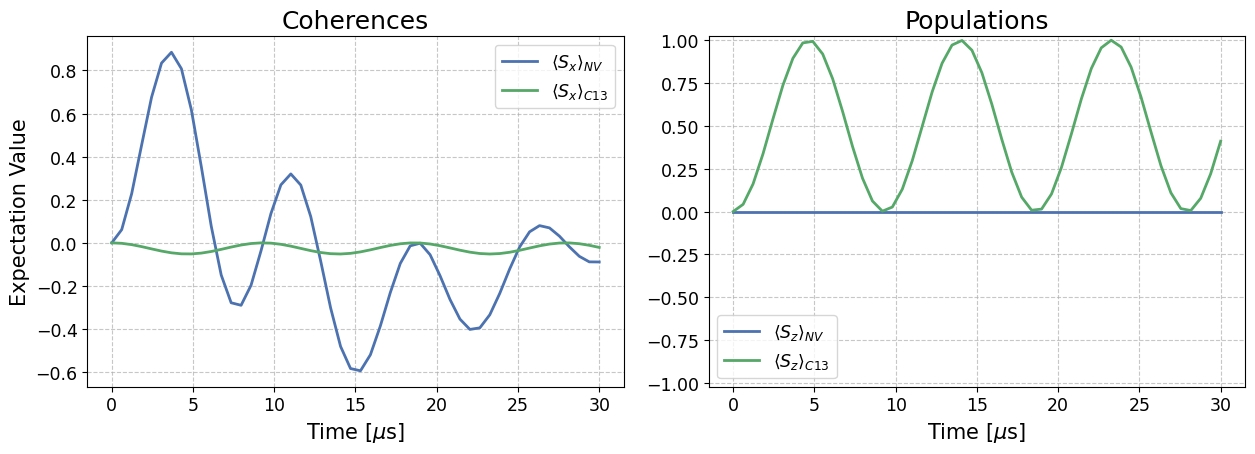

In [24]:
# full_bath thermal
fig, ax = plot_exp_values(t_list, new_states)

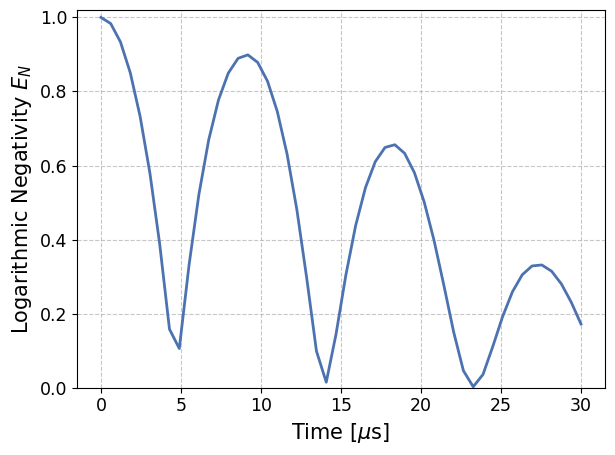

In [26]:
# full_bath thermal
log_negativities = [calc_logarithmic_negativity(new_state) for new_state in new_states] 
fig, ax = plot_log_negativity(t_list, log_negativities)

## Hahn echos

In [89]:
kwargs = dict(suter_method=True, instant_pulses=True, verbose=False, target=bell_state, thermal_bath=False)
kwargs['dynamical_decoupling'] = True
kwargs['num_hahn_echos'] = 2

env = Environment(register_config, bath_configs, **kwargs)
pulse_seq = [0, 3.93e-6, 2.95e-6, 2.28e-6, 0.30e-6, -1.06, 4.68, 2.07, 0, -0.53, 6.26, -1.76, 0]
env.get_values(pulse_seq, 'fidelity', t_list='final')

[np.float64(0.9982118532412574)]

In [91]:
kwargs = dict(suter_method=True, instant_pulses=True, verbose=False, target=bell_state, thermal_bath=False)
kwargs['num_hahn_echos'] = 2

env = Environment(register_config, bath_configs, **kwargs)
pulse_seq = [0, 4.06620465e-6, 1.57022726e-6, 1.50788214e-6, 0.99813568, 3.57557112, 1.68300382, 0.69459264, 1.97327426, 0.50816523]
env.get_values(pulse_seq, 'fidelity', t_list='final')

[np.float64(0.9997793580086438)]

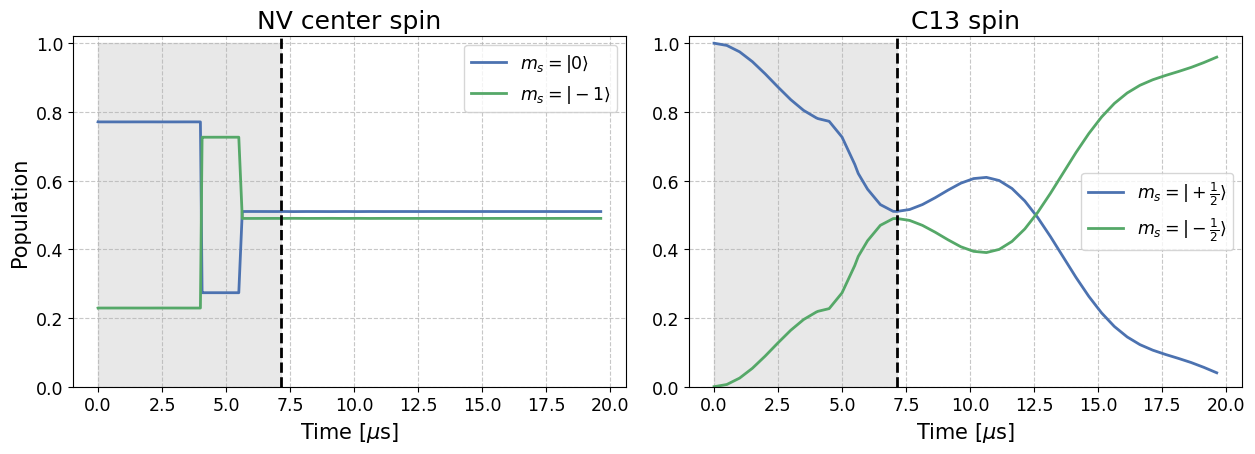

In [92]:
t_list = list(env.t_list)
t_list.extend( np.arange(env.total_time, 20e-6, 0.5e-6) )
    
new_register_states = env.get_new_register_states(pulse_seq, t_list=t_list)
fig, ax = plot_pops(t_list, new_register_states, pulse_time=env.total_time)

## Bell State Preparation with Dynamical Decoupling (Dominik, Fig. 7)

In [85]:
kwargs = dict(suter_method=True, instant_pulses=True, verbose=False, target=bell_state, thermal_bath=False)
kwargs['dynamical_decoupling'] = True

env = Environment(register_config, bath_configs, **kwargs)
pulse_seq = [0, 3.93e-6, 2.95e-6, 2.28e-6, 0.30e-6, -1.06, 4.68, 2.07, 0, -0.53, 6.26, -1.76, 0]
env.get_values(pulse_seq, 'fidelity', t_list='final')

[np.float64(0.9982118532412574)]

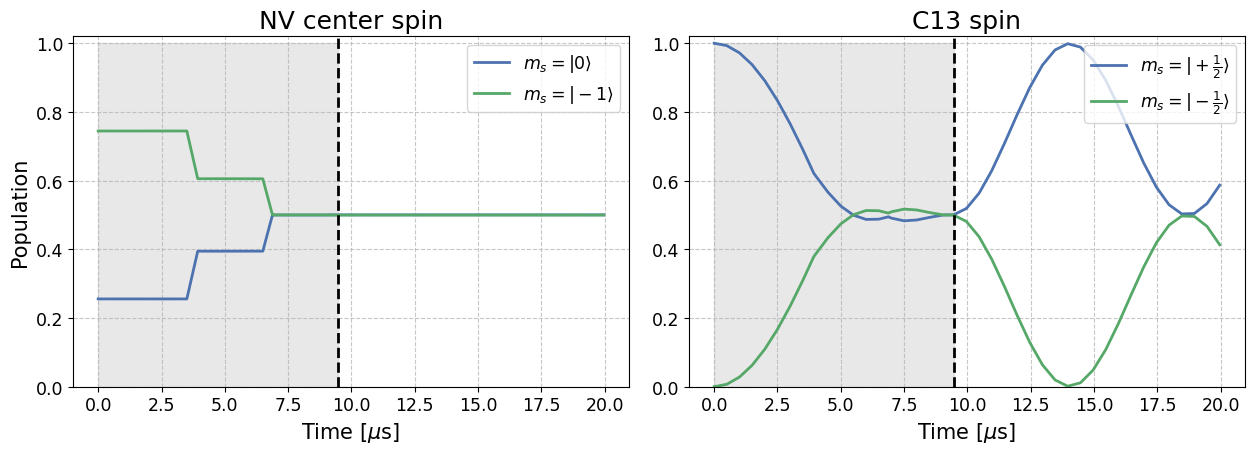

In [86]:
t_list = list(env.t_list)
t_list.extend( np.arange(env.total_time, 20e-6, 0.5e-6) )
    
new_register_states = env.get_new_register_states(pulse_seq, t_list=t_list)
fig, ax = plot_pops(t_list, new_register_states, pulse_time=env.total_time)

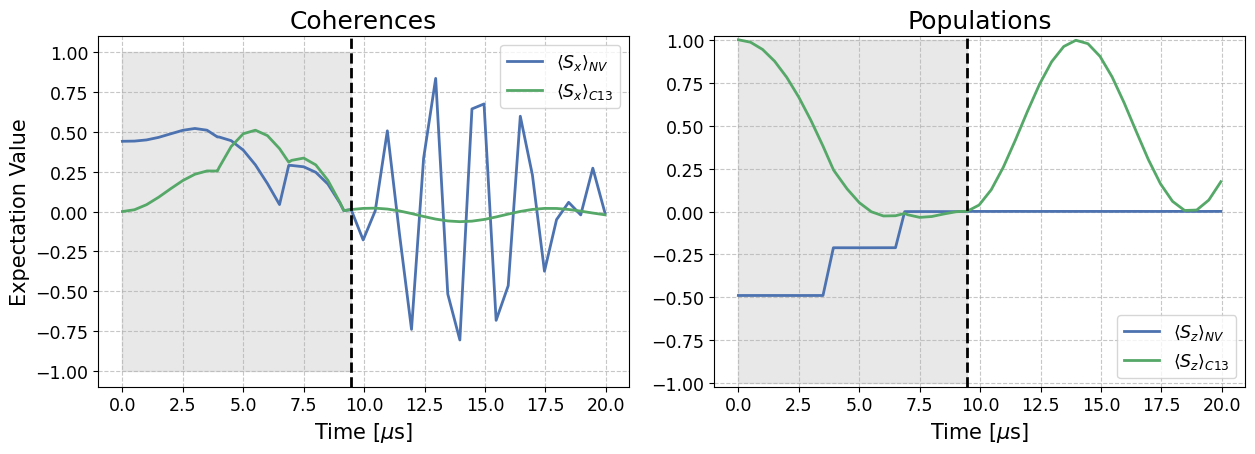

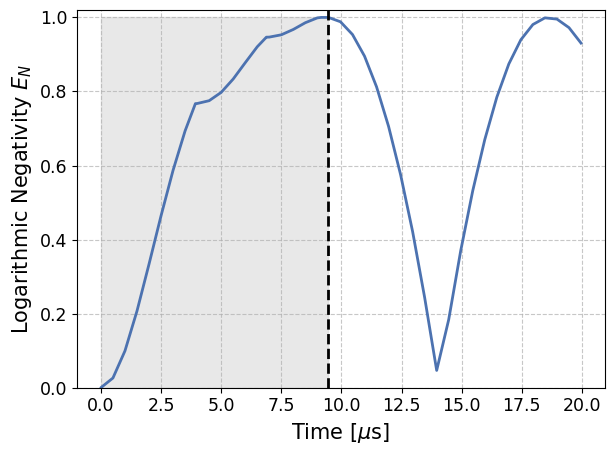

In [87]:
fig, ax = plot_exp_values(t_list, new_register_states, pulse_time=env.total_time)

log_negativities = [calc_logarithmic_negativity(new_state) for new_state in new_register_states] 
fig, ax = plot_log_negativity(t_list, log_negativities, pulse_time=env.total_time)

## Bell State Preparation (Dominik, Fig. 4)

In [79]:
kwargs = dict(suter_method=True, instant_pulses=True, verbose=False, target=bell_state, thermal_bath=False)

env = Environment(register_config, bath_configs, **kwargs)
pulse_seq = [0, 4.06620465e-6, 1.57022726e-6, 1.50788214e-6, 0.99813568, 3.57557112, 1.68300382, 0.69459264, 1.97327426, 0.50816523]
env.get_values(pulse_seq, 'fidelity', t_list='final')

[np.float64(0.9997793580086438)]

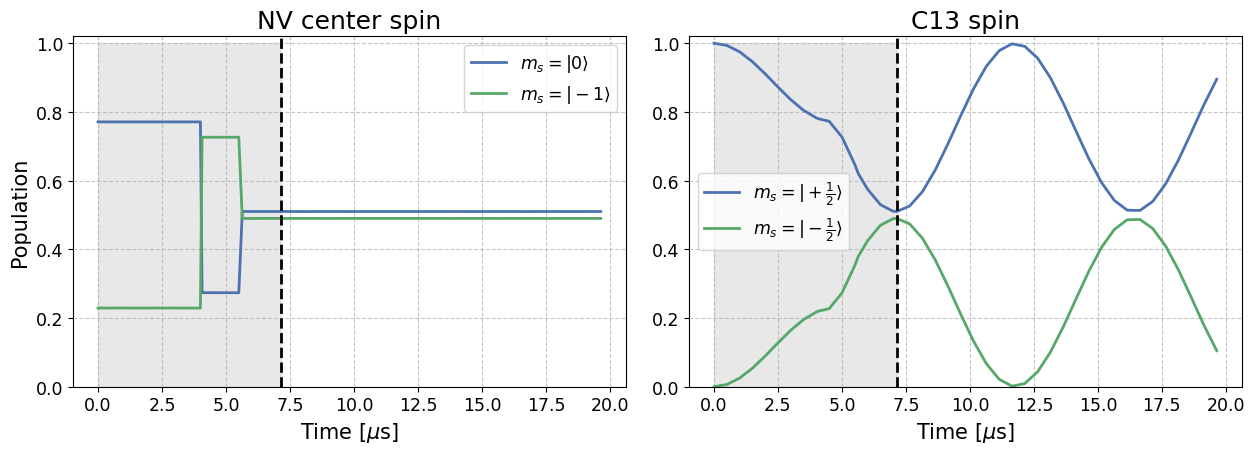

In [81]:
t_list = list(env.t_list)
t_list.extend( np.arange(env.total_time, 20e-6, 0.5e-6) )
    
new_register_states = env.get_new_register_states(pulse_seq, t_list=t_list)
fig, ax = plot_pops(t_list, new_register_states, pulse_time=env.total_time)

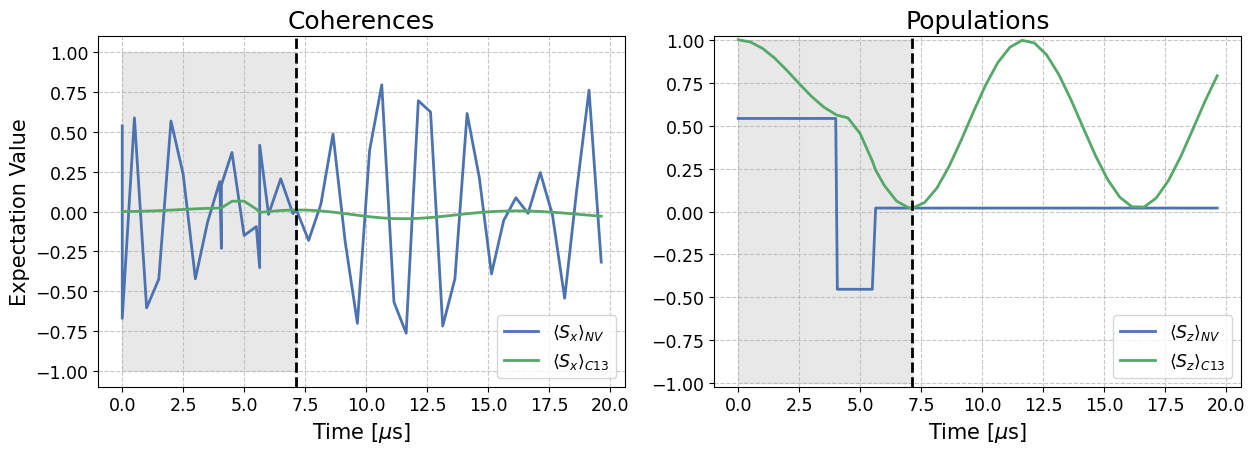

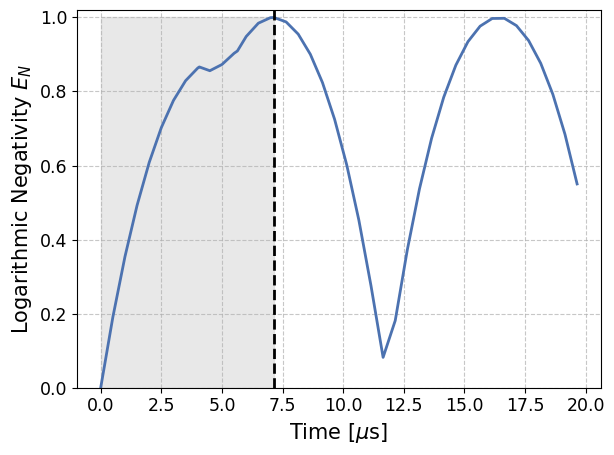

In [83]:
fig, ax = plot_exp_values(t_list, new_register_states, pulse_time=env.total_time)

log_negativities = [calc_logarithmic_negativity(new_state) for new_state in new_register_states] 
fig, ax = plot_log_negativity(t_list, log_negativities, pulse_time=env.total_time)